In [8]:
# First Cell - Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn
import joblib

# Configure MLflow
print("Setting up MLflow...")
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("spam_detection")
print("MLflow setup complete!")
print(np.__version__)

Setting up MLflow...
MLflow setup complete!
1.24.3


In [9]:
# Second Cell - Load Data
print("Loading data...")
df = pd.read_csv('../data/preprocessed_data.csv')
print(f"Dataset shape: {df.shape}")

# Handle NaN values
df['cleaned_text'] = df['cleaned_text'].fillna('')

# Show sample data
print("\nFirst few examples:")
display(df[['cleaned_text', 'label']].head())

# Show class distribution
print("\nClass distribution (%):")
print(df['label'].value_counts(normalize=True) * 100)

Loading data...
Dataset shape: (5574, 5)

First few examples:


,cleaned_text,label
0,go jurong point crazy available bugis n great ...,0
1,ok lar joking wif u oni,0
2,free entry wkly comp win fa cup final tkts st ...,1
3,u dun say early hor u c already say,0
4,nah dont think goes usf lives around though,0



Class distribution (%):
label
0    86.598493
1    13.401507
Name: proportion, dtype: float64


In [10]:
# Third Cell - Feature Creation
print("Creating text features...")
vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2)
)

# Transform text to features
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Features created successfully!")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Creating text features...
Features created successfully!
Training set shape: (4459, 5000)
Testing set shape: (1115, 5000)


In [11]:
# Fourth Cell - Model Training with MLflow
# Define parameters
param_grid = {
    'n_estimators': [100],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Create base model
rf = RandomForestClassifier(random_state=42)

# Setup grid search
print("Setting up Grid Search...")
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

Setting up Grid Search...


In [12]:
# Train with MLflow tracking
print("Starting model training...")
with mlflow.start_run(run_name="spam_detection_training"):
    # Perform grid search
    grid_search.fit(X_train, y_train)
    
    # Get best parameters
    best_params = grid_search.best_params_
    print(f"\nBest parameters: {best_params}")
    
    # Log parameters
    mlflow.log_params(best_params)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Test set evaluation
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        "test_accuracy": accuracy_score(y_test, y_pred),
        "test_precision": precision_score(y_test, y_pred),
        "test_recall": recall_score(y_test, y_pred),
        "test_f1": f1_score(y_test, y_pred)
    }
    
    # Log metrics
    for metric_name, value in metrics.items():
        mlflow.log_metric(metric_name, value)
    
    print("\nTest Set Performance:")
    print(classification_report(y_test, y_pred))
    
    # Create models directory if doesn't exist
    import os
    os.makedirs('../models', exist_ok=True)
    
    # Save model and vectorizer
    model_data = {
        'vectorizer': vectorizer,
        'model': best_model,
        'best_params': best_params,
        'metrics': metrics
    }
    
    model_path = '../models/spam_classifier.joblib'
    joblib.dump(model_data, model_path)
    print(f"\nModel saved to: {model_path}")
    
    # Log model in MLflow
    mlflow.sklearn.log_model(best_model, "spam_classifier")

print("\nTraining complete! Check MLflow UI for details")

Starting model training...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Test Set Performance:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       966
           1       1.00      0.60      0.75       149

    accuracy                           0.95      1115
   macro avg       0.97      0.80      0.86      1115
weighted avg       0.95      0.95      0.94      1115


Model saved to: ../models/spam_classifier.joblib


2025/02/17 22:13:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run spam_detection_training at: http://localhost:5000/#/experiments/878681816147613169/runs/806c0a2eb3b6449cb12cdaceab363de4
🧪 View experiment at: http://localhost:5000/#/experiments/878681816147613169

Training complete! Check MLflow UI for details


In [14]:
# Define a more comprehensive parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],         # More trees options
    'max_depth': [10, 20, 30],              # Different depth options
    'min_samples_split': [2, 5, 10],        # Different split thresholds
    'min_samples_leaf': [1, 2, 4],          # Different leaf sizes
    'max_features': ['sqrt', 'log2']        # Feature selection methods
}

# Create base model
rf = RandomForestClassifier(random_state=42)

# Setup grid search with cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                        # 5-fold cross validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    return_train_score=True      # This will log training scores too
)

# Train with MLflow tracking
with mlflow.start_run(run_name="hyperparameter_tuning"):
    print("Starting hyperparameter tuning...")
    
    # Perform grid search
    grid_search.fit(X_train, y_train)
    
    # Log all combinations tried
    for idx, params in enumerate(grid_search.cv_results_['params']):
        with mlflow.start_run(run_name=f"trial_{idx}", nested=True):
            # Log parameters
            mlflow.log_params(params)
            
            # Log metrics for this combination
            metrics = {
                "cv_accuracy": grid_search.cv_results_['mean_test_score'][idx],
                "cv_std": grid_search.cv_results_['std_test_score'][idx],
                "train_accuracy": grid_search.cv_results_['mean_train_score'][idx],
            }
            mlflow.log_metrics(metrics)
    
    # Get best parameters
    best_params = grid_search.best_params_
    print(f"\nBest parameters found: {best_params}")
    
    # Train final model with best parameters
    with mlflow.start_run(run_name="best_model", nested=True):
        best_model = grid_search.best_estimator_
        
        # Evaluate on test set
        y_pred = best_model.predict(X_test)
        
        # Calculate final metrics
        final_metrics = {
            "test_accuracy": accuracy_score(y_test, y_pred),
            "test_precision": precision_score(y_test, y_pred),
            "test_recall": recall_score(y_test, y_pred),
            "test_f1": f1_score(y_test, y_pred)
        }
        
        # Log final metrics
        mlflow.log_metrics(final_metrics)
        
        # Log best model
        mlflow.sklearn.log_model(best_model, "spam_classifier")
        
        print("\nFinal Model Performance:")
        print(classification_report(y_test, y_pred))

# Save the model with vectorizer
model_data = {
    'vectorizer': vectorizer,
    'model': best_model,
    'best_params': best_params,
    'metrics': final_metrics
}

# Save to file
joblib.dump(model_data, '../models/spam_classifier.joblib')
print("\nModel saved successfully!")

Starting hyperparameter tuning...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
🏃 View run trial_0 at: http://localhost:5000/#/experiments/878681816147613169/runs/cef4d7c578a9446faee0fc9432154387
🧪 View experiment at: http://localhost:5000/#/experiments/878681816147613169
🏃 View run trial_1 at: http://localhost:5000/#/experiments/878681816147613169/runs/9c18e761d74e4d5bac313e6242fdfaf5
🧪 View experiment at: http://localhost:5000/#/experiments/878681816147613169
🏃 View run trial_2 at: http://localhost:5000/#/experiments/878681816147613169/runs/99b73b51d17c4d829a71f3409f9ee598
🧪 View experiment at: http://localhost:5000/#/experiments/878681816147613169
🏃 View run trial_3 at: http://localhost:5000/#/experiments/878681816147613169/runs/4825cca393dc4afb97924f3b9029ffe5
🧪 View experiment at: http://localhost:5000/#/experiments/878681816147613169
🏃 View run trial_4 at: http://localhost:5000/#/experiments/878681816147613169/runs/2b9e1692e18d4c3399e5c378db88ef85
🧪 View experime

2025/02/17 22:21:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Final Model Performance:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.75      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115

🏃 View run best_model at: http://localhost:5000/#/experiments/878681816147613169/runs/b90dc36e6c6a4d19989e64e7896db560
🧪 View experiment at: http://localhost:5000/#/experiments/878681816147613169


RestException: RESOURCE_DOES_NOT_EXIST: Run '4e6790da91414780a26f0cf60763909c' not found

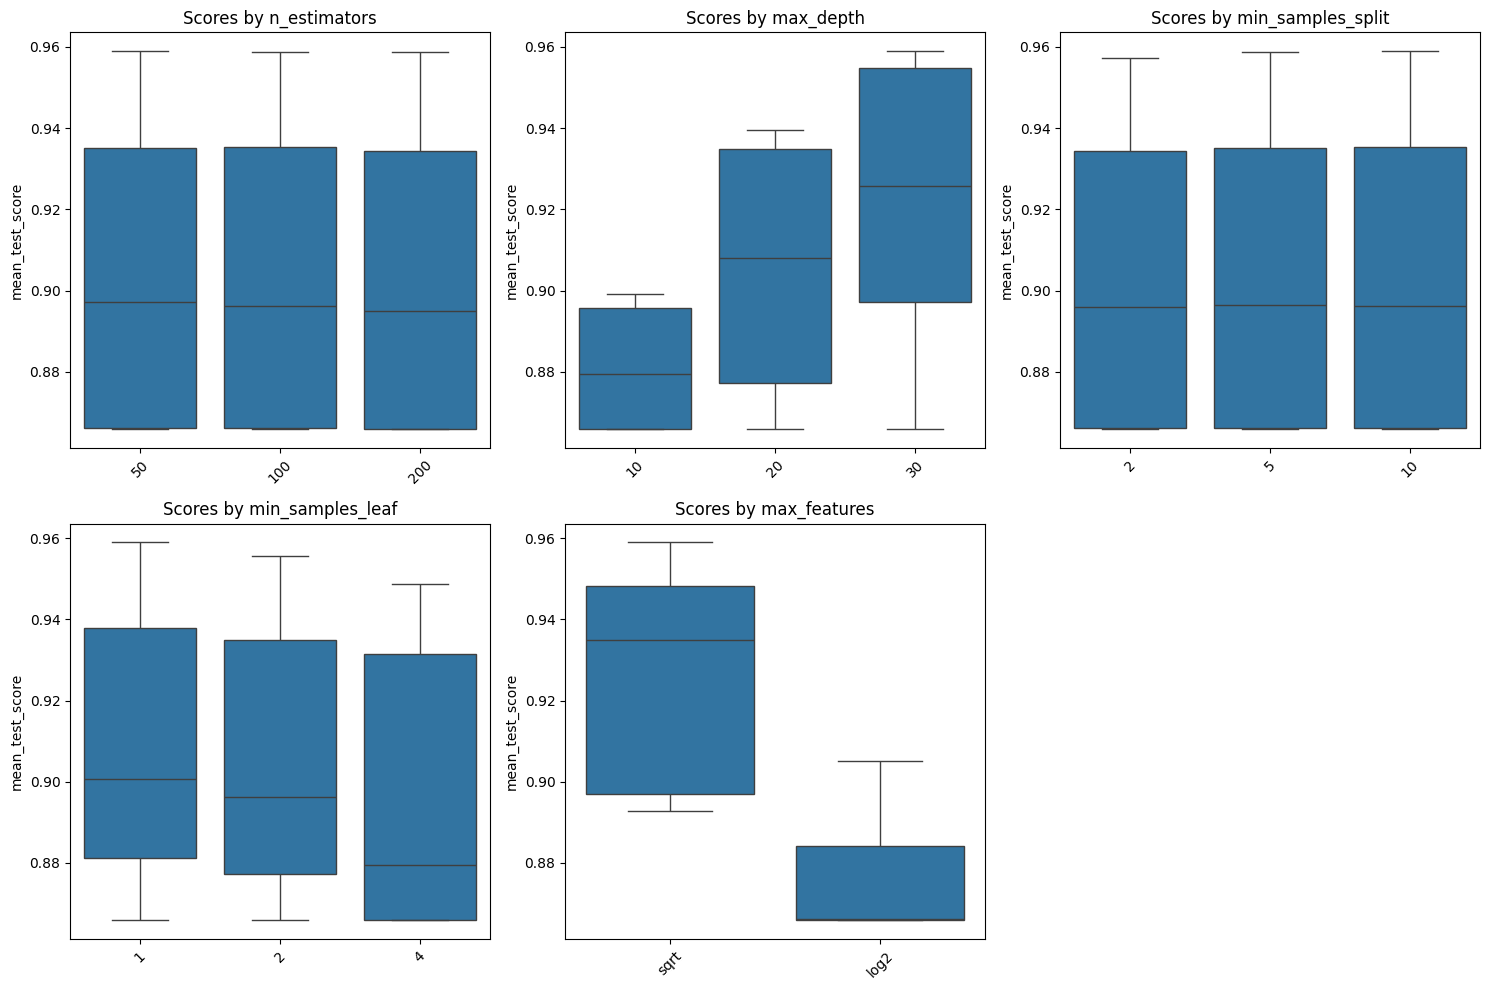

In [15]:
# Visualize parameter importance
import matplotlib.pyplot as plt
import seaborn as sns

# Get mean scores for each parameter
param_scores = pd.DataFrame(grid_search.cv_results_)
param_scores = param_scores[['params', 'mean_test_score']]

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot distributions of scores for different parameters
for idx, param in enumerate(param_grid.keys()):
    plt.subplot(2, 3, idx+1)
    param_values = [p[param] for p in param_scores['params']]
    sns.boxplot(x=param_values, y=param_scores['mean_test_score'])
    plt.title(f'Scores by {param}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()